# QOSF Task 1

In [1]:
import math
import numpy as np
from scipy import optimize
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_bloch_multivector, plot_histogram

The Swap test is a simple quantum circuit which, given two states, allows to compute how much do they differ from each other.

1. Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

**Solution:**

We construct a circuit that has one qubit, and it will do the following:
- Apply a generic rotation $U(\theta, \phi, \lambda)$ gate

This generic single qubit rotation should be able to allow us to express any point on the surface of Bloch sphere.

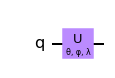

In [2]:
theta = Parameter('θ')
phi = Parameter('φ')
lam = Parameter('λ')

qc = QuantumCircuit(1)
qc.u(theta, phi, lam, 0)
qc.draw('mpl')

Now we can vary randomly the parameters and visualize the state in Bloch sphere

circuit:
Figure(494.726x84.28)
state:  [ 0.62585419+0.j         -0.58632665+0.51432245j]


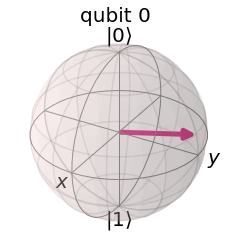

In [3]:
circuit_random = qc.bind_parameters({theta: np.random.uniform(-2*np.pi, 2*np.pi), phi: np.random.uniform(-2*np.pi, 2*np.pi), lam: np.random.uniform(-2*np.pi, 2*np.pi)})
state_random = execute(circuit_random, backend = BasicAer.get_backend('statevector_simulator')).result().get_statevector()
print('circuit:')
print(circuit_random.draw())
print('state: ', state_random)
plot_bloch_multivector(state_random)

2. Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

**Solution:**

We first define a function `swap_circuit` to construct the Swap test circuit.

In [4]:
def swap_circuit(state_1, state_2):
    """
    Given two statevector of same size, construct the Swap test circuit

    Input:
        state_1  (numpy.ndarray)     : statevector 1
        state_2  (numpy.ndarray)     : statevector 2
    Output:
        swap     (QuantumCircuit)  : qiskit QuantumCircuit
    """
    
    n = int(np.log2(len(state_1)))
    assert(n == int(np.log2(len(state_2))))
    swap = QuantumCircuit(2*n+1)
    swap.initialize(state_1, list(range(1, n+1)))
    swap.initialize(state_2, list(range(n+1, 2*n+1)))
    swap.h(0)
    for i in range(n):
        swap.cswap(0, i+1, n+i+1)
    swap.h(0)
    
    return swap

Here is an example of the Swap test circuit on two randomly generated one qubit quantum states.

state 1:  [0.51996685-0.63827193j 0.38848571-0.41391094j]
state 2:  [0.25811784+0.92826564j 0.22286162-0.14842769j]


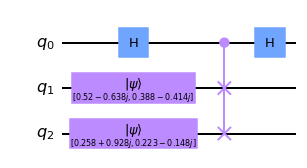

In [5]:
state_1 = random_statevector(2).data
state_2 = random_statevector(2).data
print('state 1: ', state_1)
print('state 2: ', state_2)
swap = swap_circuit(state_1, state_2)
swap.draw('mpl')

To find the best choice of parameters of the variational circuit that can reproduce the generated random state, we can think this as a maximization problem. That is, find the parameters to maximize the probability that 0 is measured in on the ancilla qubit in the Swap circuit.

We first generate a random one qubit quantum state and visualize it on the Bloch sphere.

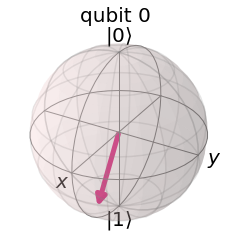

In [6]:
state_target = random_statevector(2).data
plot_bloch_multivector(state_target)

Define a `cost_function` to compute the probability that 0 is measured on the ancilla qubit in the Swap test circuit, times a -1 since conventional optimizer are minimizing.

In [7]:
def cost_function(parameters):
    """
    Given the parameters, compute the probability that 0 is measured on the ancilla qubit times -1
    since we are minimizing

    Input:
        parameters    (numpy.ndarray)  : theta, phi, lam
    Output:
        -result['0']  (float)          : negative of the probability that 0 is measured
    """
    
    circuit_test = qc.bind_parameters({theta: parameters[0], phi: parameters[1], lam: parameters[2]})
    state_test = execute(circuit_test, backend = BasicAer.get_backend('statevector_simulator')).result().get_statevector()
    swap = swap_circuit(state_target, state_test)
    result = Statevector(np.array([1, 0, 0, 0, 0, 0, 0, 0])).from_instruction(swap).probabilities_dict([0])
    
    return -result['0']

We use an optimizer `COBYLA` to find the parameters.

In [8]:
result = optimize.minimize(cost_function, np.random.uniform(-2*np.pi, 2*np.pi, 3), method = 'COBYLA')
print(result)

     fun: -0.9999999990189281
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 137
  status: 1
 success: True
       x: array([-3.4194153 , -0.64589353,  0.05014836])


We find the best parameters! Let's plot the reproduced quantum state in the Bloch sphere to verify

Find best parameters: theta: -3.419415295227598, phi: -0.6458935333195107, lam: 0.05014836122863329


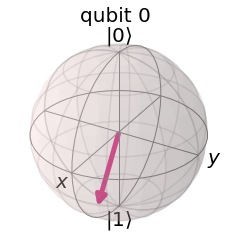

In [9]:
best_parameter = result['x']
print(f"Find best parameters: theta: {best_parameter[0]}, phi: {best_parameter[1]}, lam: {best_parameter[2]}")
circuit_reproduce = qc.bind_parameters({theta: best_parameter[0], phi: best_parameter[1], lam: best_parameter[2]})
state_reproduce = execute(circuit_reproduce, backend = BasicAer.get_backend('statevector_simulator')).result().get_statevector()
plot_bloch_multivector(state_reproduce)

3. Suppose you are given with a random state, made by $N$ qubits, for which you only know that it is a product state and each of the qubits are in the state $|0\rangle$ or $|1\rangle$. Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.

**Solution:**

We first define a function `generate_statevector` to help us generate product state.

In [10]:
def generate_statevector(binary_list):
    """
    Given a binary list, generate a product state such that each of the qubits are in the state
    |0> or |1>

    Input:
        binary_list  (numpy.ndarray)  : a binary list
    Output:
        state        (Statevector)    : qiskit statevector
    """
    
    if binary_list[0] == 0:
        state = Statevector(np.array([1, 0]))
    else:
        state = Statevector(np.array([0, 1]))
    for i in binary_list[1:]:
        if i == 0:
            state = state.expand(Statevector(np.array([1, 0])))
        else:
            state = state.expand(Statevector(np.array([0, 1])))
    
    return state

Now, let's generate a random state, made by $N$ qubit.

In [11]:
N = 4
random_list = np.random.randint(2, size = N)
print(f"Generate product state: |{ ''.join(map(str, random_list))}>")
product_state = generate_statevector(random_list)
product_state

Generate product state: |0010>


Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))

Simple grid search to reconstruct the state

In [12]:
for b in range(2**N):
    test_list = np.array([int(t) for t in reversed(list(bin(b)[2:].zfill(N)))])
    test_state = generate_statevector(test_list)
    swap_test = swap_circuit(product_state.data, test_state.data)
    initial_state = np.zeros(2**N)
    initial_state[0] = 1
    prob = Statevector(initial_state).from_instruction(swap_test).probabilities_dict([0])['0']
    if np.isclose(prob, 1):
        break
print(f"Reproduce state: |{ ''.join(map(str, test_list))}>")
test_state

Reproduce state: |0010>


Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2))